# MNIST exploring "confuison" range of failed classifications

In [37]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

In [3]:
mnist = input_data.read_data_sets("MNIST_data/",one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


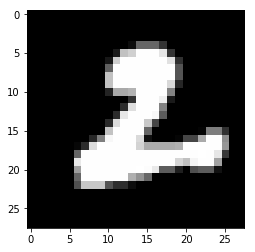

In [87]:
plt.imshow(mnist.train.images[1].reshape(28,28),cmap='gist_gray')

## Tensorflow

In [88]:

# set up tensorflow variables
x = tf.placeholder(tf.float32,shape=[None,784])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

# Create the Graph
y = tf.matmul(x,W) + b 
y_true = tf.placeholder(tf.float32,[None,10])

# Cross Entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)

train = optimizer.minimize(cross_entropy)

### Create Session

In [26]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for step in range(1000):
        
        batch_x , batch_y = mnist.train.next_batch(100)
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y})
    
    saver = tf.train.Saver()
    saver.save(sess, 'weights/confusion.ckpt')
    
    matches = tf.equal(tf.argmax(y,1),tf.argmax(y_true,1))
    acc = tf.reduce_mean(tf.cast(matches,tf.float32))
    
    print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels}))

In [28]:
with tf.Session() as sess:
    
    # restore saved model
    saver = tf.train.Saver()
    saver.restore(sess, 'weights/confusion.ckpt')
        
    batch_x , batch_y = mnist.train.images, mnist.train.labels
    pred = sess.run(y,feed_dict={x:batch_x,y_true:batch_y})
#     print(pred)

INFO:tensorflow:Restoring parameters from weights/confusion.ckpt


In [29]:
top = {}
top['Y'] = []
top['1_arg'] = []
top['1_weight'] = []
top['2_arg'] = []
top['2_weight'] = []


for i in range(pred.shape[0]):

    top['Y'].append(batch_y[i].argmax())

    # get first top prediction                 
    top['1_arg'].append(pred[i].argmax())
    top['1_weight'].append(pred[i][top['1_arg'][i]])

    #reset it in the list                
    pred[i][top['1_arg'][i]] = 0

    # now, get second top prediction                
    top['2_arg'].append(pred[i].argmax())
    top['2_weight'].append(pred[i][top['2_arg'][i]])     


In [40]:
results = pd.DataFrame(top)
results['diff'] = abs(results['1_weight'] - results['2_weight'])
results['correct'] = results['Y']==results['1_arg']

results.head()

,1_arg,1_weight,2_arg,2_weight,Y,diff,correct
0,1,9.116402,3,3.036011,1,6.080391,True
1,2,13.835535,3,5.310859,2,8.524676,True
2,3,8.560400,8,3.292883,3,5.267517,True
3,5,2.219664,9,2.122555,5,0.097109,True
4,0,10.377380,5,7.171851,0,3.205529,True


In [41]:
correct = results[results['correct']==True]
correct.head()

,1_arg,1_weight,2_arg,2_weight,Y,diff,correct
0,1,9.116402,3,3.036011,1,6.080391,True
1,2,13.835535,3,5.310859,2,8.524676,True
2,3,8.560400,8,3.292883,3,5.267517,True
3,5,2.219664,9,2.122555,5,0.097109,True
4,0,10.377380,5,7.171851,0,3.205529,True


In [42]:
wrong = results[results['correct']==False]
wrong.head()

,1_arg,1_weight,2_arg,2_weight,Y,diff,correct
7,5,4.104667,6,3.619210,6,0.485456,False
10,6,4.363631,8,3.204559,8,1.159072,False
20,6,5.810632,2,5.478035,8,0.332596,False
29,6,4.909739,2,4.291502,2,0.618237,False
34,4,4.647733,9,4.337019,9,0.310714,False


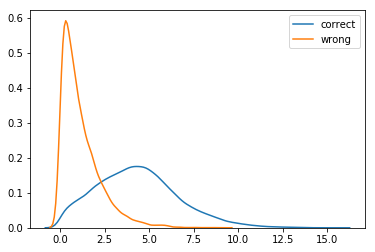

In [45]:
# sns.kdeplot(results['diff'])
sns.kdeplot(correct['diff'], label="correct")
sns.kdeplot(wrong['diff'], label="wrong")
plt.legend();

In [92]:
results['correct'].value_counts()

True     50536
False     4464
Name: correct, dtype: int64

In [94]:
1-(55000-(4464*(1-0.9684466123580933)))/55000

0.0025609876806085285